# Simple Movie Recommender App
> Simple end-to-end content-based movie recommender app built using streamlit and TMDB data

- toc: true
- badges: true
- comments: true
- categories: [TMDB, Movie, Streamlit, App, NLP]
- author: "<a href='https://github.com/campusx-official/movie-recommender-system-tmdb-dataset'>CampusX</a>"
- image:

### Tutorial video

> youtube: https://youtu.be/1xtrIEwY_zY

### Connect gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Download data from kaggle

In [ ]:
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tmdb/tmdb-movie-metadata

### Unzip the data

In [ ]:
!unzip /content/tmdb-movie-metadata.zip

### Import libraries

In [ ]:
!pip install -q streamlit

In [ ]:
import os
import ast
import pickle
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

### Load data

In [ ]:
movies = pd.read_csv('tmdb_5000_movies.csv')
credits = pd.read_csv('tmdb_5000_credits.csv')

In [ ]:
movies.head(2)

In [ ]:
movies.shape

(4803, 20)

In [ ]:
credits.head()

### Merge credits data with movies on title column

In [ ]:
movies = movies.merge(credits,on='title')

In [ ]:
movies.head()

### Select important features

In [ ]:
movies = movies[['movie_id','title','overview','genres','keywords','cast','crew']]

In [ ]:
movies.head()

### Extract name values from dictionaries of genre and keywords column

In [ ]:
def convert(text):
    L = []
    for i in ast.literal_eval(text):
        L.append(i['name']) 
    return L 

In [ ]:
movies.dropna(inplace=True)

In [ ]:
movies['genres'] = movies['genres'].apply(convert)
movies.head()

In [ ]:
movies['keywords'] = movies['keywords'].apply(convert)
movies.head()

### Extract name values from dictionaries of cast column

In [ ]:
def convert3(text):
    L = []
    counter = 0
    for i in ast.literal_eval(text):
        if counter < 3:
            L.append(i['name'])
        counter+=1
    return L 

In [ ]:
movies['cast'] = movies['cast'].apply(convert)
movies.head()

In [ ]:
movies['cast'] = movies['cast'].apply(lambda x:x[0:3])

### Extract name values from dictionaries of director column

In [ ]:
def fetch_director(text):
    L = []
    for i in ast.literal_eval(text):
        if i['job'] == 'Director':
            L.append(i['name'])
    return L 

In [ ]:
movies['crew'] = movies['crew'].apply(fetch_director)

### Convert overview column's string to list

In [ ]:
movies['overview'] = movies['overview'].apply(lambda x:x.split())
movies.sample(5)

### Remove extra spaces

In [ ]:
def collapse(L):
    L1 = []
    for i in L:
        L1.append(i.replace(" ",""))
    return L1

In [ ]:
movies['cast'] = movies['cast'].apply(collapse)
movies['crew'] = movies['crew'].apply(collapse)
movies['genres'] = movies['genres'].apply(collapse)
movies['keywords'] = movies['keywords'].apply(collapse)

In [ ]:
movies.head()

### Combine all list into single columns named ```tag```

In [ ]:
movies['tags'] = movies['overview'] + movies['genres'] + movies['keywords'] + movies['cast'] + movies['crew']

In [ ]:
new = movies.drop(columns=['overview','genres','keywords','cast','crew'])
new.head()

,movie_id,title,tags
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin..."
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d..."
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send..."
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney..."
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili..."


In [ ]:
new['tags'] = new['tags'].apply(lambda x: " ".join(x))
new.head()

,movie_id,title,tags
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha..."
2,206647,Spectre,A cryptic message from Bond’s past sends him o...
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...
4,49529,John Carter,"John Carter is a war-weary, former military ca..."


### Build count vectorizer model

In [ ]:
cv = CountVectorizer(max_features=5000,stop_words='english')    

In [ ]:
vector = cv.fit_transform(new['tags']).toarray()

In [ ]:
vector.shape

(4806, 5000)

### Calculate cosine similarity

In [ ]:
similarity = cosine_similarity(vector)

In [ ]:
similarity

array([[1.        , 0.08964215, 0.06071767, ..., 0.02519763, 0.0277885 ,
        0.        ],
       [0.08964215, 1.        , 0.06350006, ..., 0.02635231, 0.        ,
        0.        ],
       [0.06071767, 0.06350006, 1.        , ..., 0.02677398, 0.        ,
        0.        ],
       ...,
       [0.02519763, 0.02635231, 0.02677398, ..., 1.        , 0.07352146,
        0.04774099],
       [0.0277885 , 0.        , 0.        , ..., 0.07352146, 1.        ,
        0.05264981],
       [0.        , 0.        , 0.        , ..., 0.04774099, 0.05264981,
        1.        ]])

In [ ]:
new[new['title'] == 'The Lego Movie'].index[0]

744

### Create recommender

In [ ]:
def recommend(movie):
    index = new[new['title'] == movie].index[0]
    distances = sorted(list(enumerate(similarity[index])),reverse=True,key = lambda x: x[1])
    for i in distances[1:6]:
        print(new.iloc[i[0]].title)

In [ ]:
recommend('Gandhi')

Gandhi, My Father
The Wind That Shakes the Barley
A Passage to India
Guiana 1838
Ramanujan


### Save the movie list and similarity matrix as pickle

In [ ]:
pickle.dump(new,open('movie_list.pkl','wb'))
pickle.dump(similarity,open('similarity.pkl','wb'))

### Streamlit app

In [ ]:
%%writefile app.py
import pickle
import streamlit as st
import requests

def fetch_poster(movie_id):
    url = "https://api.themoviedb.org/3/movie/{}?api_key=8265bd1679663a7ea12ac168da84d2e8&language=en-US".format(movie_id)
    data = requests.get(url)
    data = data.json()
    poster_path = data['poster_path']
    full_path = "https://image.tmdb.org/t/p/w500/" + poster_path
    return full_path

def recommend(movie):
    index = movies[movies['title'] == movie].index[0]
    distances = sorted(list(enumerate(similarity[index])), reverse=True, key=lambda x: x[1])
    recommended_movie_names = []
    recommended_movie_posters = []
    for i in distances[1:6]:
        # fetch the movie poster
        movie_id = movies.iloc[i[0]].movie_id
        recommended_movie_posters.append(fetch_poster(movie_id))
        recommended_movie_names.append(movies.iloc[i[0]].title)

    return recommended_movie_names,recommended_movie_posters


st.header('Movie Recommender System')
movies = pickle.load(open('model/movie_list.pkl','rb'))
similarity = pickle.load(open('model/similarity.pkl','rb'))

movie_list = movies['title'].values
selected_movie = st.selectbox(
    "Type or select a movie from the dropdown",
    movie_list
)

if st.button('Show Recommendation'):
    recommended_movie_names,recommended_movie_posters = recommend(selected_movie)
    col1, col2, col3, col4, col5 = st.beta_columns(5)
    with col1:
        st.text(recommended_movie_names[0])
        st.image(recommended_movie_posters[0])
    with col2:
        st.text(recommended_movie_names[1])
        st.image(recommended_movie_posters[1])

    with col3:
        st.text(recommended_movie_names[2])
        st.image(recommended_movie_posters[2])
    with col4:
        st.text(recommended_movie_names[3])
        st.image(recommended_movie_posters[3])
    with col5:
        st.text(recommended_movie_names[4])
        st.image(recommended_movie_posters[4])

Writing app.py


### Run the app

In [5]:
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(9999)"))

https://ru7u8kn5coj-496ff2e9c6d22116-9999-colab.googleusercontent.com/


In [ ]:
!nohup streamlit run app.py &
!pip install -q colab-everything
from colab_everything import ColabStreamlit
ColabStreamlit('app.py')

nohup: appending output to 'nohup.out'
Web App can be accessed on: http://be0f82826a82.ngrok.io

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:9999
  External URL: http://34.91.184.167:9999



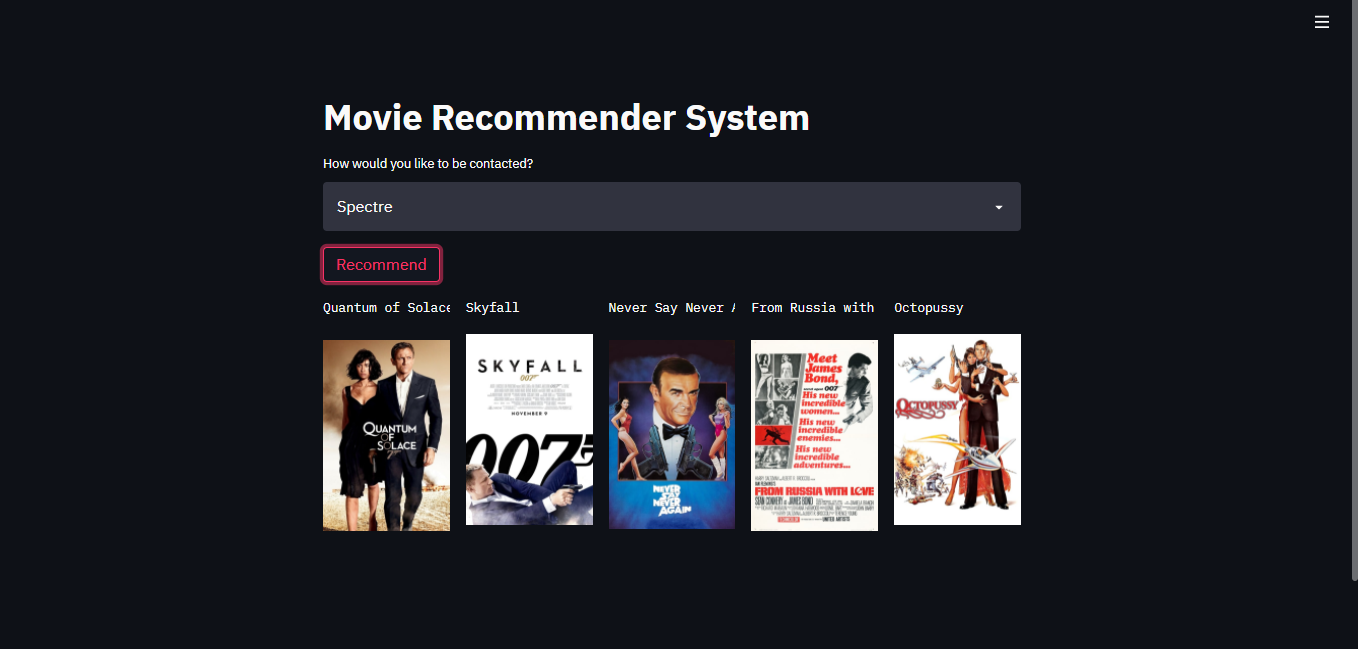